In [14]:
import torch
from torch import Tensor
from torch.utils.data import DataLoader
from model import GPT
from data_fetcher import (
    get_padded_image,
    get_line,
    extract_patch,
    get_line_data,
    extract_patches,
    generate_training_data,
    get_answer_triplet,
    compare_model_answer,
)
import einops
import matplotlib.pyplot as plt
from type_tree import TypeTree
import pandas as pd

### Get Model

In [2]:
window = 40
div = 16
input_dim = window**2 * 4 * 3
model = GPT(
    num_layers=3,
    d_model=256,
    num_heads=8,
    d_hidden=2048,
    input_dim=input_dim,
).to(device="cuda")
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)


def loss_fn(prediction, target):
    # row-wise MSE loss
    squared_diff = (prediction - target) ** 2
    row_wise_sum = torch.sum(squared_diff, dim=1)
    row_wise_mse = torch.mean(row_wise_sum)
    return row_wise_mse


def row_wise_loss_fn(prediction, target):
    squared_diff = (prediction - target) ** 2
    row_wise_sum = torch.sum(squared_diff, dim=1)
    return row_wise_sum

In [3]:
input_dim

19200

### Training

In [4]:
image = get_padded_image("./juneau2k.jpg", window).to("cuda")

/opt/miniconda3/lib/python3.10/site-packages/PIL/Image.py:3167: DecompressionBombWarning: Image size (122880000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


In [25]:
image.shape

torch.Size([3, 9680, 12880])

In [29]:
tt(
    extract_patch(
        image,
        torch.tensor([image.shape[1] // 2, image.shape[2] // 2]),
        window,
        window,
        reshape=False,
    )
)

hi!
torch.Size([3, 9680, 12880])
Tensor (dtype: torch.float32)
    |__dim_0 (3)
    |__dim_1 (80)
    |__dim_2 (80)


In [5]:
d = get_line_data([0, 1, 2, 3, 4])
train, test = d[0], d[1]

In [15]:
tt = TypeTree()

In [22]:
train_xs, train_ys = zip(*list(train))
train_xs = torch.stack(train_xs)
train_ys = torch.stack(train_ys)
test_xs, test_ys = zip(*list(test))
test_xs = torch.stack(test_xs)
test_ys = torch.stack(test_ys)

In [24]:
tt(train_xs)

Tensor (dtype: torch.float64)
    |__dim_0 (5768)
    |__dim_1 (2)
    |__dim_2 (2)


In [31]:
training_data = generate_training_data(image, train_xs, window, vectorize=False)

In [19]:
train_losses = []
test_losses = []

In [32]:
tt(training_data)

Tensor (dtype: torch.float32)
    |__dim_0 (5768)
    |__dim_1 (2)
    |__dim_2 (0)


In [21]:
training_data[0]

tensor([[0.2314, 0.2392, 0.4000, 0.4078, 0.2980, 0.3059, 0.4510, 0.4588, 0.0824,
         0.0902, 0.2392, 0.2471],
        [0.1961, 0.2000, 0.4118, 0.3961, 0.2627, 0.2667, 0.4510, 0.4353, 0.0510,
         0.0549, 0.2431, 0.2314]], device='cuda:0')

In [10]:
size = window
epochs = 1000
model = model.to("cuda")
training_data = training_data.to("cuda").float()
train_ys = train_ys.to(device="cuda").float()
test_ys = test_ys.to(device="cuda").float()
for epoch in range(epochs):
    optimizer.zero_grad()
    prediction = model(training_data)[:, -1]
    loss = loss_fn(prediction, train_ys)
    with torch.no_grad():
        prediction = model(testing_data)[:, -1]
        test_loss = loss_fn(prediction, test_ys)
    train_losses.append(loss)
    test_losses.append(test_loss)
    print(f"Epoch: {epoch} | Test Loss: {loss} | Train Loss: {test_loss}")
    loss.backward()
    optimizer.step()

RuntimeError: mat1 and mat2 shapes cannot be multiplied (11536x12 and 19200x256)

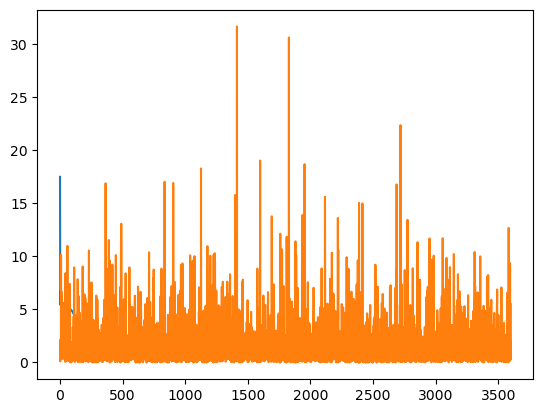

In [ ]:
def numpy(v):
    return v.detach().cpu().numpy()


plot_losses = [list(map(lambda v: numpy(v), l)) for l in [train_losses, test_losses]]
plot_losses[0][0]
plt.plot(plot_losses[0])
plt.plot(plot_losses[1])
plt.show()

In [ ]:
tt(test_xs[0])
tt(train_xs)
tt(train_ys)

Tensor (dtype: torch.float64)
    |__dim_0 (2)
    |__dim_1 (2)
Tensor (dtype: torch.float64)
    |__dim_0 (3603)
    |__dim_1 (2)
    |__dim_2 (2)
Tensor (dtype: torch.float32)
    |__dim_0 (3603)
    |__dim_1 (2)


In [ ]:
input = (train_xs[0].to("cuda"), train_ys[0].to("cuda"))

In [ ]:
tt(input)

tuple
    |__Tensor (dtype: torch.float64)
    |   |__dim_0 (2)
    |   |__dim_1 (2)
    |__Tensor (dtype: torch.float32)
        |__dim_0 (2)


In [ ]:
input

(tensor([[4596., 2485.],
         [4599., 2485.]], device='cuda:0', dtype=torch.float64),
 tensor([5., 1.], device='cuda:0'))

In [ ]:
ex_ans = get_answer_triplet(image, input, size)

In [ ]:
tt(ex_ans)

tuple
    |__Tensor (dtype: torch.float32)
    |   |__dim_0 (2)
    |   |__dim_1 (3)
    |   |__dim_2 (80)
    |   |__dim_3 (80)
    |__Tensor (dtype: torch.float32)
        |__dim_0 (3)
        |__dim_1 (80)
        |__dim_2 (80)


In [ ]:
def to_im(patch):
    return einops.rearrange(patch, "c h w -> h w c")

In [ ]:
model_input = einops.rearrange(ex_ans[0], "seq color h  w -> 1 seq (color h w)")

In [ ]:
model_ans = model(model_input)

In [ ]:
tt(input[0][1])
tt(model_ans[0, -1])

Tensor (dtype: torch.float64)
    |__dim_0 (2)
Tensor (dtype: torch.float32)
    |__dim_0 (2)


In [ ]:
model_ans_position = input[0][1] + model_ans[0, -1].round().int()

In [ ]:
model_image = extract_patch(image, model_ans_position, size, reshape=False)

In [ ]:
tt(model_image)

Tensor (dtype: torch.float32)
    |__dim_0 (3)
    |__dim_1 (80)
    |__dim_2 (80)


In [ ]:
tt(model_ans[0, -1])

Tensor (dtype: torch.float32)
    |__dim_0 (2)


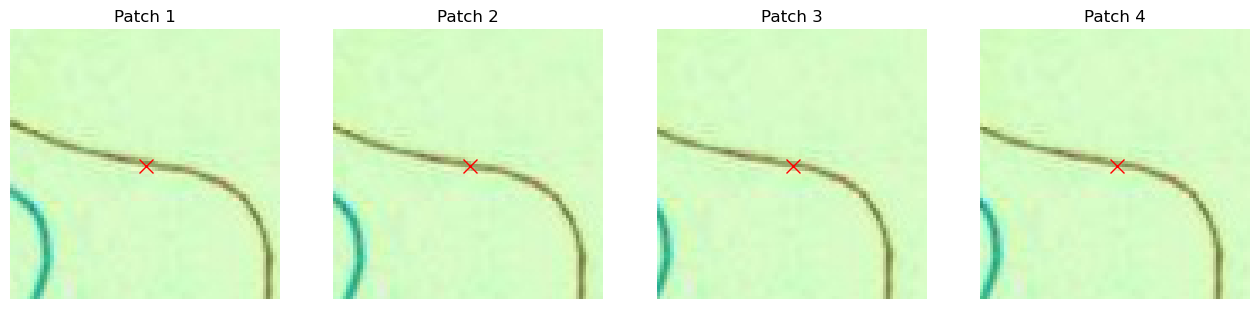

In [ ]:
patch1 = numpy(ex_ans[0][0])
patch2 = numpy(ex_ans[0][1])
patch3 = numpy(ex_ans[1])
ans = numpy(model_image)
fig, axs = plt.subplots(1, 4, figsize=(16, 4))  # 1 row, 4 columns

patches = [patch1, patch2, patch3, ans]

for i, ax in enumerate(axs):
    ax.imshow(to_im(patches[i]))
    ax.set_title(f"Patch {i+1}")

    # Calculate the center coordinates
    H = W = patches[i].shape[
        1
    ]  # Assuming patches are 2D or have shape (H, W, Channels)

    # Draw an 'x' at the center
    ax.plot(W / 2, H / 2, marker="x", markersize=10, color="red")

    ax.axis("off")

plt.show()

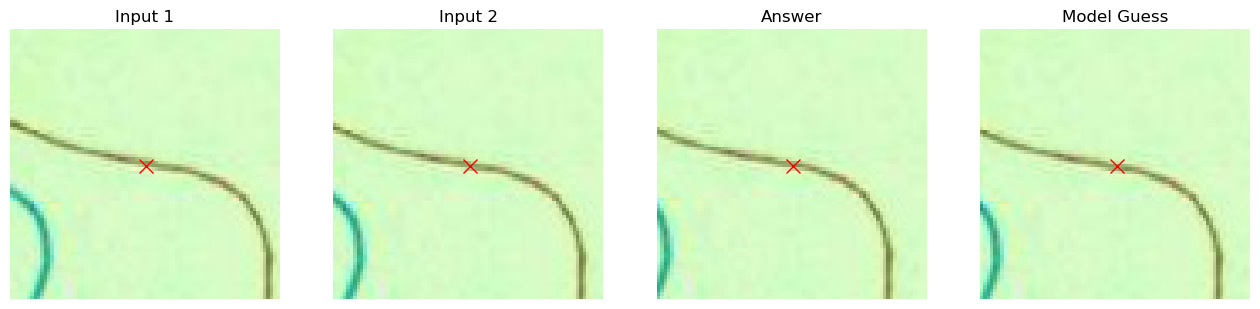

In [ ]:
compare_model_answer(image, model, input, size)

In [ ]:
test_preds = model(testing_data)
test_losses = row_wise_loss_fn(test_preds[:, -1], test_ys)

In [ ]:
tt(test_preds)
tt(test_ys)

Tensor (dtype: torch.float32)
    |__dim_0 (3602)
    |__dim_1 (2)
    |__dim_2 (2)
Tensor (dtype: torch.float32)
    |__dim_0 (3602)
    |__dim_1 (2)


In [ ]:
tt(test_losses)

Tensor (dtype: torch.float32)
    |__dim_0 (3602)


In [ ]:
sorted_loss_values, sorted_loss_indices = torch.sort(test_losses)

In [ ]:
sorted_loss_indices[-1]

tensor(1413, device='cuda:0')

In [ ]:
sorted_loss_values[-1]

tensor(31.6554, device='cuda:0', grad_fn=<SelectBackward0>)

In [ ]:
for i in sorted_loss_values:
    print(i)

tensor(4.7039e-05, device='cuda:0', grad_fn=<UnbindBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<UnbindBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<UnbindBackward0>)
tensor(0.0005, device='cuda:0', grad_fn=<UnbindBackward0>)
tensor(0.0008, device='cuda:0', grad_fn=<UnbindBackward0>)
tensor(0.0010, device='cuda:0', grad_fn=<UnbindBackward0>)
tensor(0.0015, device='cuda:0', grad_fn=<UnbindBackward0>)
tensor(0.0016, device='cuda:0', grad_fn=<UnbindBackward0>)
tensor(0.0018, device='cuda:0', grad_fn=<UnbindBackward0>)
tensor(0.0020, device='cuda:0', grad_fn=<UnbindBackward0>)
tensor(0.0022, device='cuda:0', grad_fn=<UnbindBackward0>)
tensor(0.0033, device='cuda:0', grad_fn=<UnbindBackward0>)
tensor(0.0033, device='cuda:0', grad_fn=<UnbindBackward0>)
tensor(0.0036, device='cuda:0', grad_fn=<UnbindBackward0>)
tensor(0.0040, device='cuda:0', grad_fn=<UnbindBackward0>)
tensor(0.0045, device='cuda:0', grad_fn=<UnbindBackward0>)
tensor(0.0053, device='cuda:0', grad_fn=<UnbindBackw

In [ ]:
tt(input)

tuple
    |__Tensor (dtype: torch.float64)
    |   |__dim_0 (2)
    |   |__dim_1 (2)
    |__Tensor (dtype: torch.float32)
        |__dim_0 (2)


In [ ]:
def give_input_at(xs, ys, index):
    return (xs[index].to("cuda"), ys[index].to("cuda"))

In [ ]:
worst_input = give_input_at(test_xs, test_ys, 1001)

In [ ]:
worst_input_im = extract_patches(image, worst_input[0], size=size, reshape=True)

In [ ]:
tt(worst_input_im)

Tensor (dtype: torch.float32)
    |__dim_0 (2)
    |__dim_1 (19200)


In [ ]:
model_guess_worst = model(worst_input_im.unsqueeze(0))

In [ ]:
tt(model_guess_worst)

Tensor (dtype: torch.float32)
    |__dim_0 (1)
    |__dim_1 (2)
    |__dim_2 (2)


In [ ]:
row_wise_loss_fn(model_guess_worst[:, -1], worst_input[1])

tensor([0.1884], device='cuda:0', grad_fn=<SumBackward1>)

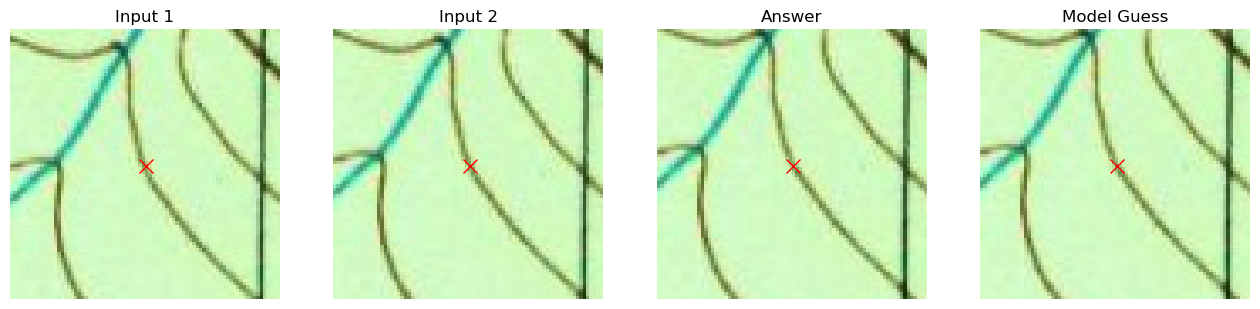

In [ ]:
compare_model_answer(image, model, worst_input, size)

In [ ]:
dat = get_line_data([0], split=False)
tt(dat)
xs = torch.stack([d[0] for d in dat])
tt(xs)
im_data = generate_training_data(image, xs, window)
tt(im_data)

list: 1370
    |__tuple
        |__Tensor (dtype: torch.float64)
        |   |__dim_0 (2)
        |   |__dim_1 (2)
        |__Tensor (dtype: torch.float64)
            |__dim_0 (2)
Tensor (dtype: torch.float64)
    |__dim_0 (1370)
    |__dim_1 (2)
    |__dim_2 (2)
Tensor (dtype: torch.float32)
    |__dim_0 (1370)
    |__dim_1 (2)
    |__dim_2 (19200)


In [ ]:
predictions = model(im_data)[:, -1]

In [ ]:
tt(predictions)

Tensor (dtype: torch.float32)
    |__dim_0 (1370)
    |__dim_1 (2)


In [ ]:
predicted_points = (xs[:, -1]) + predictions.to("cpu")

In [ ]:
tt(predicted_points)

Tensor (dtype: torch.float64)
    |__dim_0 (1370)
    |__dim_1 (2)


In [ ]:
df = pd.DataFrame(numpy(predicted_points), columns=["x", "y"])
df.insert(0, "line index", 0)

df.to_csv("./model_prediction.csv", index=False, header=False)

In [ ]:
dat = get_line_data(range(5), generate_targets=False, flattened=False, split=False)
tt(dat)
patches = [
    torch.stack([extract_patches(image, position, size) for position in positions])
    for positions in dat
]
tt(patches)
predicted_jumps = [model(inputs).to("cpu") for inputs in patches]
tt(predicted_jumps)
predicted_points = [
    jumps[:, -1] + inputs[:, -1] for jumps, inputs in zip(dat, predicted_jumps)
]
tt(predicted_points)
print(predicted_points[0].shape)
indexed_points = [
    torch.cat([torch.ones(line.shape[0], 1) * i, line], 1)
    for i, line in enumerate(predicted_points)
]
tt(indexed_points)
csvable_points = torch.cat(indexed_points)
tt(csvable_points)

list: 5
    |__Tensor (dtype: torch.float64)
        |__dim_0 (1370)
        |__dim_1 (2)
        |__dim_2 (2)
list: 5
    |__Tensor (dtype: torch.float32)
        |__dim_0 (1370)
        |__dim_1 (2)
        |__dim_2 (19200)
list: 5
    |__Tensor (dtype: torch.float32)
        |__dim_0 (1370)
        |__dim_1 (2)
        |__dim_2 (2)
list: 5
    |__Tensor (dtype: torch.float64)
        |__dim_0 (1370)
        |__dim_1 (2)
torch.Size([1370, 2])
list: 5
    |__Tensor (dtype: torch.float64)
        |__dim_0 (1370)
        |__dim_1 (3)
Tensor (dtype: torch.float64)
    |__dim_0 (7205)
    |__dim_1 (3)


In [ ]:
df = pd.DataFrame(numpy(csvable_points), columns=["index", "x", "y"])

df.to_csv("./model_prediction.csv", index=False, header=False)

In [ ]:
csvable_points[2][0]

tensor(0., dtype=torch.float64, grad_fn=<SelectBackward0>)